# <center> 9.2 - Продвинутый feature engeneering </center>

In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

In [89]:
car_info = pd.read_csv('../data/car_info.csv')   # car_info - информация про машины с таргетом
 
rides_info = pd.read_csv('../data/rides_info.csv') # rides_info - информация про поездки

In [90]:
rides_info = rides_info.merge(car_info, on = 'car_id', how = 'left')

In [4]:
drop_cols = ['user_id', 'car_id', 'ride_id', 'ride_date']
cat_cols = ['car_type', 'fuel_type', 'model']

In [5]:
# закодируем категориальные фичи в one hot encoding вектора
rides_info = pd.get_dummies(rides_info, columns=cat_cols)

In [6]:
# заполним пропущенные значения медианным значением по столбцу
rides_info.fillna(rides_info.median(), inplace=True)

### Возьмем реализацию MLP с двумя головами на PyTorch из предыдущего ноутбука

In [7]:
rides_df = rides_info.drop(columns=drop_cols)

In [10]:
# переведем строковые значения категориального таргета в целочисленные
le = LabelEncoder()
rides_df['target_class'] = le.fit_transform(rides_df['target_class'])

### GaussRankScaler - SOTA scaler для нейросетей, показывает лучший скор, чем скейлеры из sklearn

In [11]:
# для нормализации данных используем ранк гаусс трансформацию. 
# импортнем библеотеку и добавим путь к ней 
#!git clone https://github.com/aldente0630/gauss-rank-scaler
import sys
sys.path.append('./gauss-rank-scaler')

In [12]:
# числовые переменные, которые подвергнем трансформации
num_cols = [col for col in list(rides_df.columns)
            if col not in ['target_reg', 'target_class']]

In [13]:
from gauss_rank_scaler import GaussRankScaler

scaler = GaussRankScaler()
df = scaler.fit_transform(rides_df[num_cols])

In [14]:
df = pd.DataFrame(df, columns=num_cols)

In [15]:
target_scaler = GaussRankScaler()
target = target_scaler.fit_transform(rides_df['target_reg'].values.reshape(-1, 1))

In [16]:
df['target_reg'] = target
df['target_class'] = rides_df['target_class']

In [17]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import os
import copy

In [19]:
# для наших данных и размера нейросети подойдет запуск на cpu
device = torch.device('cpu')

In [20]:
# ВАЖНО! - фиксируем воспроизводимость
def seed_everything(seed=42):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [21]:
# можно попробовать поэкспериментировать с параметрами
class CFG:
    hidden_size=128
    dropout=0.1
    lr=1e-3
    batch_size=128
    num_workers=4
    epochs=20
    num_features=train.shape[1]-2 # кол-во фичей подаваемое на вход
    num_tar_2=train.target_class.nunique() # количество выходов равно кол-ву предсказываемых классов

In [22]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx,:]
        
        data = row.drop(labels=['target_reg', 'target_class'])
        
        data = torch.FloatTensor(data.values.astype('float'))
        tar_1 = torch.tensor(row['target_reg']).float()
        tar_2 = row['target_class'].astype('int')
        
        return data, tar_1, tar_2

In [23]:
# проверим корректность работы методов нашего класса
next(iter(Rides(train)))

(tensor([-0.3788, -2.3073, -1.9011, -0.2533, -0.4003, -2.7511, -0.0485, -2.7511,
          1.0343,  0.0570, -0.7821,  2.7511,  1.0915,  0.2255, -2.7511,  2.7511,
         -2.7511, -2.7511, -2.7511,  2.7511, -2.7511, -2.7511, -2.7511, -2.7511,
         -2.7511, -2.7511, -2.7511, -2.7511, -2.7511, -2.7511, -2.7511, -2.7511,
         -2.7511, -2.7511, -2.7511, -2.7511, -2.7511, -2.7511, -2.7511, -2.7511,
          2.7511, -2.7511, -2.7511, -2.7511, -2.7511, -2.7511]),
 tensor(-1.8217),
 4)

In [30]:
dataset = Rides(df)
dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=CFG.batch_size, 
                                        shuffle=False, 
                                        num_workers=CFG.num_workers)

In [36]:
# Построим архитектуру mlp с двумя головами для регрессии и классифкации

class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(cfg.num_features, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size//2),
                          )
        
        self.regressor = nn.Sequential(
            nn.Linear(cfg.hidden_size//2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size//2, cfg.num_tar_2)
        )

    def forward(self, data):
        x = self.mlp(data)
        tar1 = self.regressor(x)
        tar2 = self.classifier(x)
        return x

## Возмем сохраненные веса модели из предыдущего ноутбука и модифицируем архитектуру нейросети для извлечения эмбеддингов.

In [37]:
model = TabularNN(CFG)
PATH = '../others/tab_model.pth'
model.load_state_dict(torch.load(PATH))

model.classifier = torch.nn.Identity()
model.regressor = torch.nn.Identity()
model.to(device)
model.eval()

TabularNN(
  (mlp): Sequential(
    (0): Linear(in_features=46, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Identity()
  (classifier): Identity()
)

In [39]:
embeddings = []

with torch.no_grad():
    for inputs, labels_1, labels_2 in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        embeddings.extend(outputs.detach().cpu().numpy())

In [93]:
embed_df = pd.DataFrame(data=embeddings, 
                        columns=[f'embed_{i}' for i in range(embeddings[0].shape[0])])
embed_df.head()

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,0.569995,-0.301826,0.093389,0.345503,-0.614546,-0.247425,-0.310597,0.015119,-0.435127,-0.196682,...,0.019641,-0.316610,0.448188,0.049708,0.028220,0.002913,-0.370401,0.040142,-0.042063,-0.252882
1,0.559573,-0.307709,0.100099,0.329651,-0.596167,-0.250978,-0.329809,0.008835,-0.415401,-0.167196,...,-0.008394,-0.304418,0.417113,0.049360,0.030227,-0.004504,-0.358658,0.037824,-0.051398,-0.214406
2,0.591875,-0.390991,0.098490,0.353997,-0.604785,-0.217619,-0.330511,-0.002951,-0.424126,-0.168109,...,-0.003113,-0.370895,0.501207,0.048665,0.030116,-0.007108,-0.368241,-0.035432,-0.004754,-0.136696
3,0.574146,-0.319524,0.068230,0.335044,-0.617978,-0.275925,-0.322312,0.011938,-0.444151,-0.186536,...,0.035989,-0.343062,0.458915,0.044886,0.027910,0.002141,-0.363914,0.044208,-0.060244,-0.284149
4,0.492001,-0.307489,0.065185,0.274998,-0.500355,-0.313267,-0.379409,0.006240,-0.392294,-0.148153,...,0.048186,-0.310231,0.335939,0.051280,0.030229,-0.011079,-0.332299,0.054850,-0.090703,-0.198243


## Добавим эмбеддинги к нашему датасету и попробуем обучить бустинг

In [47]:
df = pd.concat((df, embed_df) ,axis=1)
df.head()

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,-0.270392,-0.208171,0.006968,-0.665254,-1.176543,-0.775351,1.129246,-2.751064,-0.040963,0.057055,...,0.019641,-0.316610,0.448188,0.049708,0.028220,0.002913,-0.370401,0.040142,-0.042063,-0.252882
1,0.128511,-0.008539,0.270110,-0.440310,-0.721824,-2.751064,1.227936,-2.751064,-0.056420,0.057055,...,-0.008394,-0.304418,0.417113,0.049360,0.030227,-0.004504,-0.358658,0.037824,-0.051398,-0.214406
2,0.101565,-2.619869,-2.232926,0.253684,0.236051,-2.751064,-0.829857,-2.751064,-0.133146,-0.025080,...,-0.003113,-0.370895,0.501207,0.048665,0.030116,-0.007108,-0.368241,-0.035432,-0.004754,-0.136696
3,-0.085114,-2.215034,-1.669811,-0.440310,-0.797256,-2.751064,0.411810,-2.751064,-0.094856,0.057055,...,0.035989,-0.343062,0.458915,0.044886,0.027910,0.002141,-0.363914,0.044208,-0.060244,-0.284149
4,0.395691,-2.248530,-1.856967,-0.629319,-0.943408,-1.195047,-0.129080,-2.751064,-0.089672,0.057055,...,0.048186,-0.310231,0.335939,0.051280,0.030229,-0.011079,-0.332299,0.054850,-0.090703,-0.198243


In [58]:
from catboost import CatBoostClassifier, Pool

In [50]:
X = df.drop(['target_reg','target_class'], axis=1)
y = df['target_class']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True)

In [54]:
clf.fit( X_train, y_train, 
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(clf.get_best_score())

Learning rate set to 0.122678
0:	learn: 1.9761098	test: 1.9763741	best: 1.9763741 (0)	total: 274ms	remaining: 4m 33s
50:	learn: 0.7826116	test: 0.7874224	best: 0.7874224 (50)	total: 9.66s	remaining: 2m 59s
100:	learn: 0.6638714	test: 0.6698649	best: 0.6698649 (100)	total: 18.3s	remaining: 2m 43s
150:	learn: 0.5788628	test: 0.5853031	best: 0.5853031 (150)	total: 26.6s	remaining: 2m 29s
200:	learn: 0.5124200	test: 0.5191893	best: 0.5191893 (200)	total: 35.2s	remaining: 2m 19s
250:	learn: 0.4477208	test: 0.4548852	best: 0.4548852 (250)	total: 43.9s	remaining: 2m 10s
300:	learn: 0.3979376	test: 0.4057531	best: 0.4057531 (300)	total: 52.8s	remaining: 2m 2s
350:	learn: 0.3570371	test: 0.3651174	best: 0.3651174 (350)	total: 1m 1s	remaining: 1m 54s
400:	learn: 0.3191370	test: 0.3274946	best: 0.3274946 (400)	total: 1m 10s	remaining: 1m 45s
450:	learn: 0.2869130	test: 0.2957593	best: 0.2957593 (450)	total: 1m 19s	remaining: 1m 36s
500:	learn: 0.2584140	test: 0.2671478	best: 0.2671478 (500)	total

In [57]:
# Посмотрим важность признаков
fi = clf.get_feature_importance(prettified=True)
fi[:30]

,Feature Id,Importances
0,car_rating,9.097169
1,riders,8.393540
2,year_to_work,4.413221
3,embed_32,3.898194
4,embed_41,2.077531
5,embed_45,2.038018
6,embed_62,2.021022
7,embed_36,1.915279
8,year_to_start,1.774338
9,embed_51,1.746314


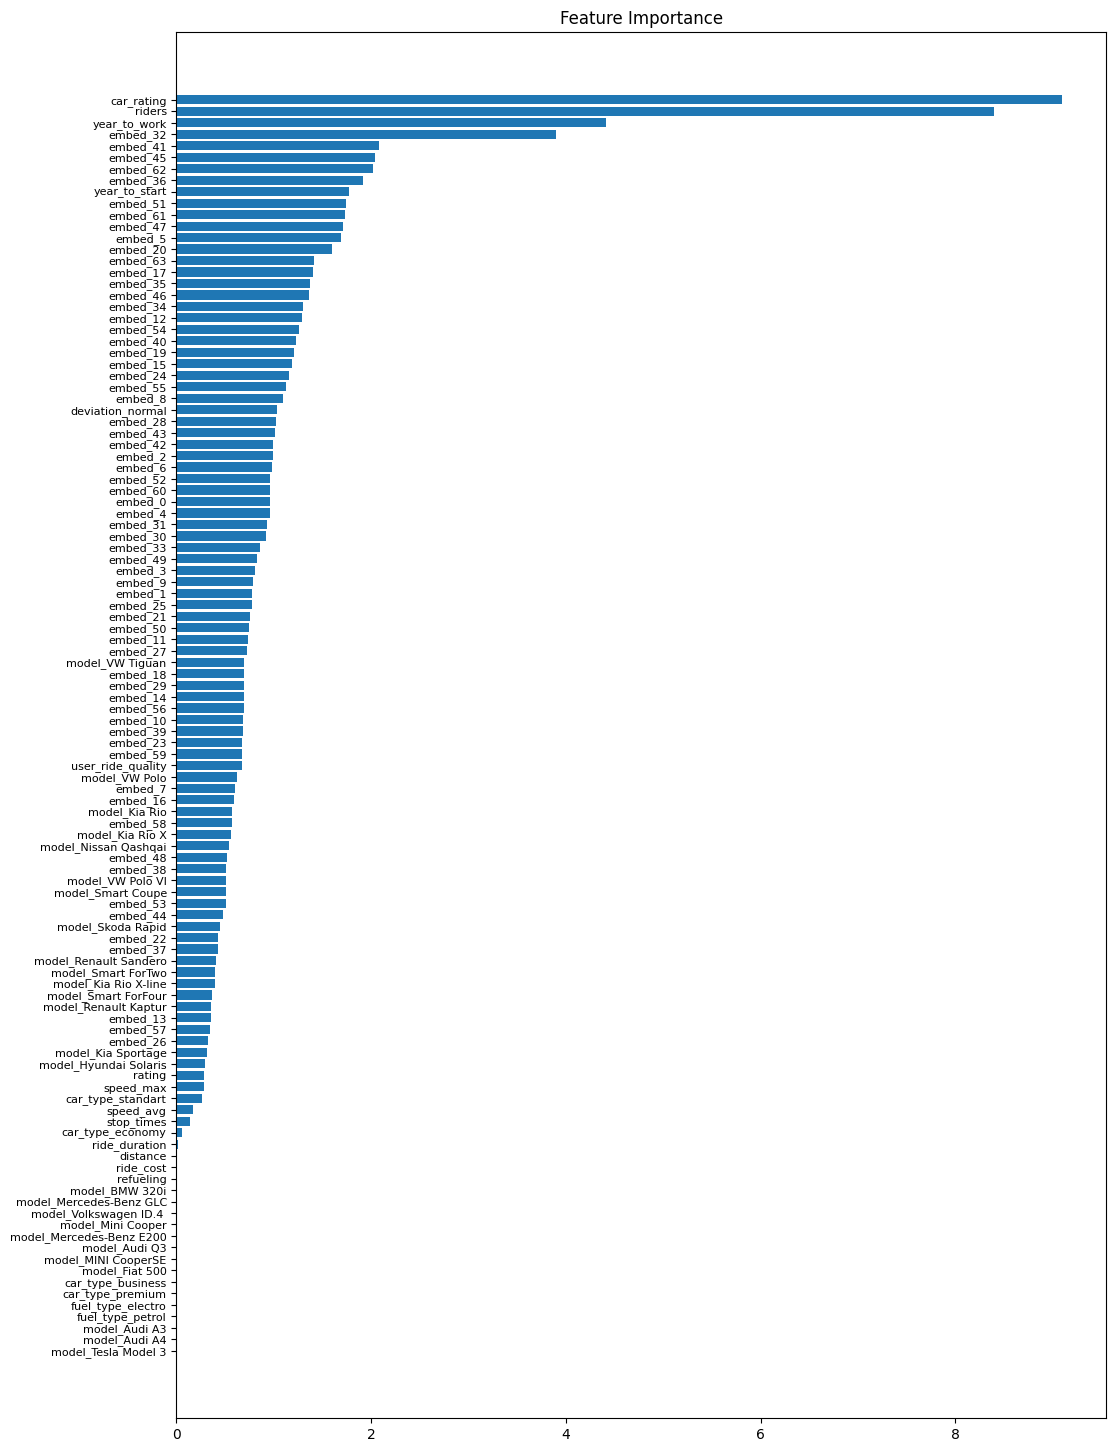

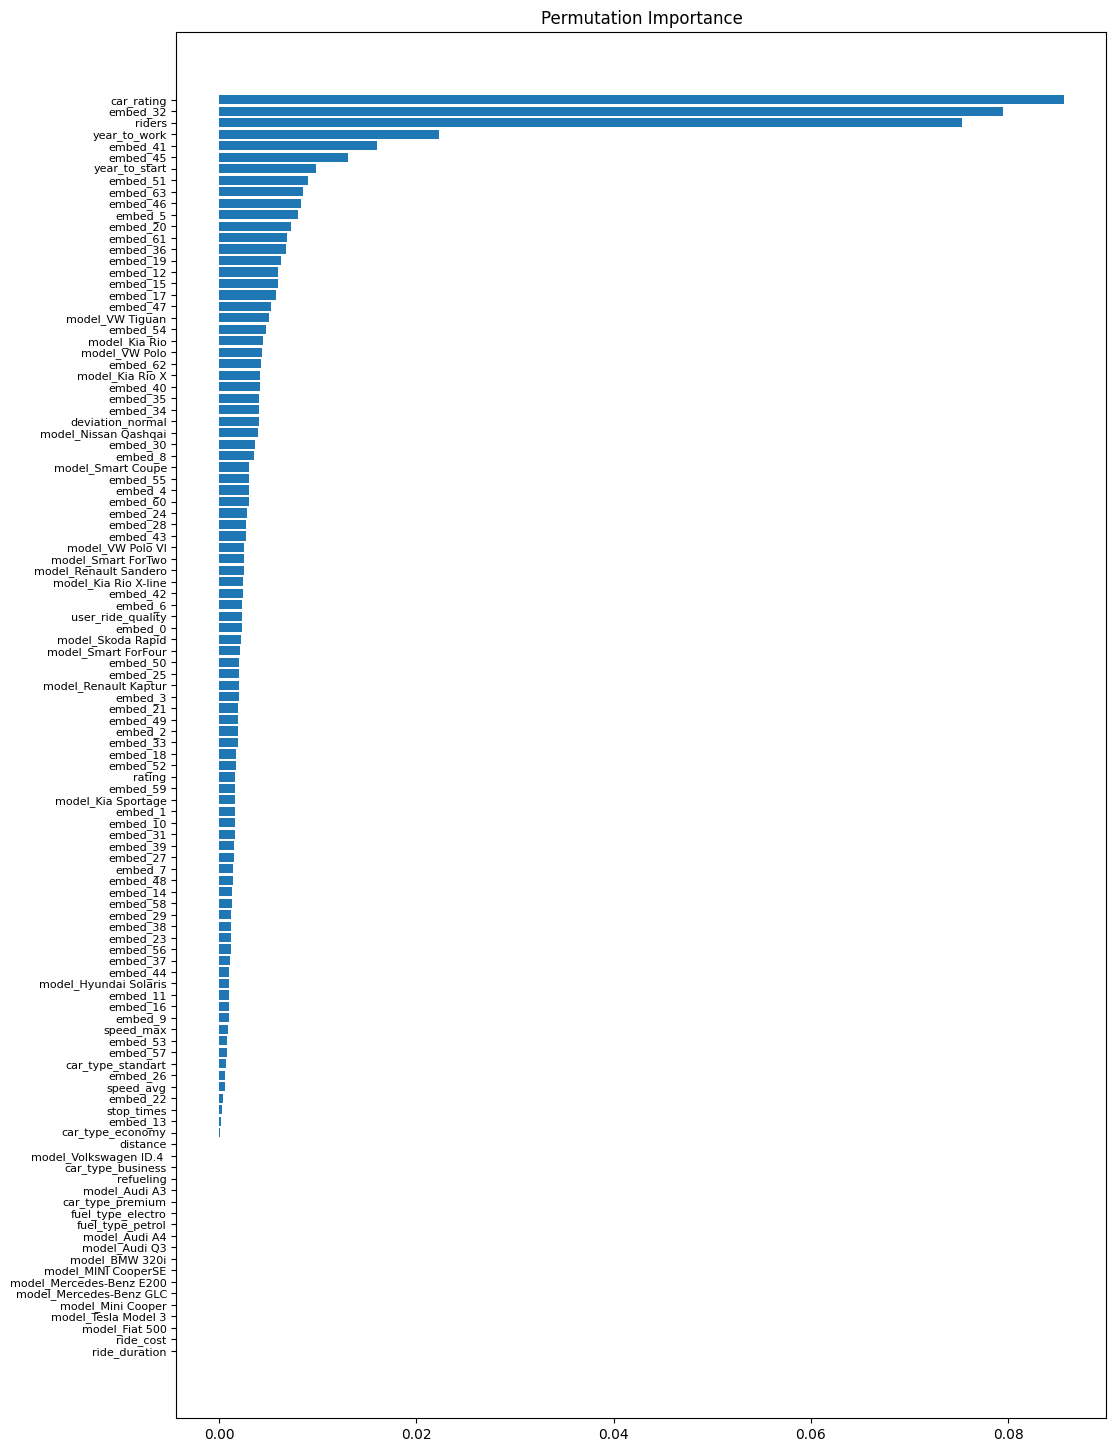

In [95]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 18))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=8)
plt.title('Feature Importance');

perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 18))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=8)
plt.title('Permutation Importance');

### Как видно, из графиков эмбеддинги являются сильными признаками

In [69]:
preds = clf.predict(X_test)
f1_score(y_test, preds, average='macro')

0.9822474550346869

Скор модели, обученной на эмбеддингах выше, чем у нейросети